### Transfer learning

#### Main intuition: 
- Train a model using a specific set of training data
- Save the model
- Use the pre-trained model for a new problem/dataset
- Re-train using the new dataset

#### When do we use it:
If we have a small dataset, not big enough for proper training. The use of a pre-trained model on much larger dataset provides a better initialization

#### Examples:
The most common example is: ImageNet network + transfer learning to specific dataset


In [0]:
from __future__ import print_function

!pip install q keras==2.3.1

import datetime
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


In [0]:
now = datetime.datetime.now

batch_size = 128
num_classes = 5
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
filters = 32
# size of pooling area for max pooling
pool_size = 2
# convolution kernel size
kernel_size = 3


In [0]:
K.backend()

'tensorflow'

In [0]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)


In [0]:
def train_model(model, train, test, num_classes):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    t = now()
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    print('Training time: %s' % (now() - t))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])


In [0]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [0]:
# create two datasets one with digits below 5 and one with 5 and above
x_train_lt5 = x_train[y_train < 5]
y_train_lt5 = y_train[y_train < 5]
x_test_lt5 = x_test[y_test < 5]
y_test_lt5 = y_test[y_test < 5]

x_train_gte5 = x_train[y_train >= 5]
y_train_gte5 = y_train[y_train >= 5] - 5
x_test_gte5 = x_test[y_test >= 5]
y_test_gte5 = y_test[y_test >= 5] - 5



In [0]:
# define two groups of layers: feature (convolutions) and classification (dense)
feature_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax')
]


In [0]:
# create complete model
model = Sequential(feature_layers + classification_layers)


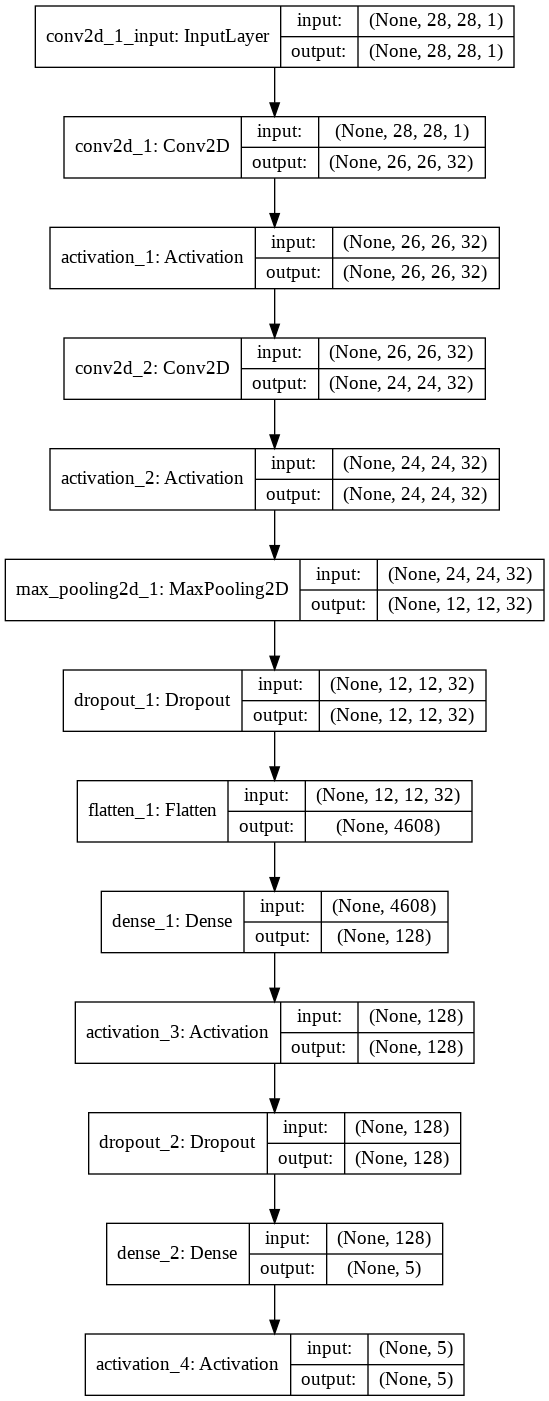

In [0]:
from keras.utils import plot_model

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model, show_shapes=True, show_layer_names=True)

In [0]:
# train model for 5-digit classification [0..4]
train_model(model,
            (x_train_lt5, y_train_lt5),
            (x_test_lt5, y_test_lt5), num_classes)


x_train shape: (30596, 28, 28, 1)
30596 train samples
5139 test samples
Train on 30596 samples, validate on 5139 samples
Epoch 1/5
30596/30596 [==============================] - 49s 2ms/step - loss: 0.1637 - accuracy: 0.9488 - val_loss: 0.0325 - val_accuracy: 0.9905
Epoch 2/5
30596/30596 [==============================] - 49s 2ms/step - loss: 0.0491 - accuracy: 0.9860 - val_loss: 0.0159 - val_accuracy: 0.9944
Epoch 3/5
30596/30596 [==============================] - 48s 2ms/step - loss: 0.0319 - accuracy: 0.9907 - val_loss: 0.0134 - val_accuracy: 0.9944
Epoch 4/5
30596/30596 [==============================] - 48s 2ms/step - loss: 0.0272 - accuracy: 0.9917 - val_loss: 0.0078 - val_accuracy: 0.9971
Epoch 5/5
30596/30596 [==============================] - 48s 2ms/step - loss: 0.0221 - accuracy: 0.9930 - val_loss: 0.0083 - val_accuracy: 0.9967
Training time: 0:04:03.773571
Test score: 0.008321681414331934
Test accuracy: 0.9966919422149658


In [0]:
# freeze feature  layers and rebuild model
for l in feature_layers:
    l.trainable = False


In [0]:

# transfer: train dense layers for new classification task [5..9]
train_model(model,
            (x_train_gte5, y_train_gte5),
            (x_test_gte5, y_test_gte5), num_classes)

x_train shape: (29404, 28, 28, 1)
29404 train samples
4861 test samples
Train on 29404 samples, validate on 4861 samples
Epoch 1/5
29404/29404 [==============================] - 17s 564us/step - loss: 0.0420 - accuracy: 0.9869 - val_loss: 0.0250 - val_accuracy: 0.9912
Epoch 2/5
29404/29404 [==============================] - 16s 556us/step - loss: 0.0394 - accuracy: 0.9884 - val_loss: 0.0227 - val_accuracy: 0.9934
Epoch 3/5
29404/29404 [==============================] - 16s 560us/step - loss: 0.0346 - accuracy: 0.9895 - val_loss: 0.0235 - val_accuracy: 0.9926
Epoch 4/5
29404/29404 [==============================] - 16s 559us/step - loss: 0.0337 - accuracy: 0.9892 - val_loss: 0.0233 - val_accuracy: 0.9924
Epoch 5/5
29404/29404 [==============================] - 16s 559us/step - loss: 0.0328 - accuracy: 0.9904 - val_loss: 0.0210 - val_accuracy: 0.9934
Training time: 0:01:22.717211
Test score: 0.02103791343513074
Test accuracy: 0.993416965007782
